## importing

In [ ]:
import time
import numpy as np
import gradio as gr
import pandas as pd
import seaborn as sns
from io import BytesIO
import matplotlib.pyplot as plt

sns.set()

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV,RandomizedSearchCV

from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

## reading dataset and uderstand it

In [ ]:
df = pd.read_csv('../death/causes-of-death.csv')
df.head()

,Year,113 Cause Name,Cause Name,State,Deaths,Age-adjusted Death Rate
0,2017,"Accidents (unintentional injuries) (V01-X59,Y8...",Unintentional injuries,United States,169936,49.4
1,2017,"Accidents (unintentional injuries) (V01-X59,Y8...",Unintentional injuries,Alabama,2703,53.8
2,2017,"Accidents (unintentional injuries) (V01-X59,Y8...",Unintentional injuries,Alaska,436,63.7
3,2017,"Accidents (unintentional injuries) (V01-X59,Y8...",Unintentional injuries,Arizona,4184,56.2
4,2017,"Accidents (unintentional injuries) (V01-X59,Y8...",Unintentional injuries,Arkansas,1625,51.8


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10868 entries, 0 to 10867
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Year                     10868 non-null  int64  
 1   113 Cause Name           10868 non-null  object 
 2   Cause Name               10868 non-null  object 
 3   State                    10868 non-null  object 
 4   Deaths                   10868 non-null  int64  
 5   Age-adjusted Death Rate  10868 non-null  float64
dtypes: float64(1), int64(2), object(3)
memory usage: 509.6+ KB


### checking for nulls and duplicates

In [ ]:
df.isnull().sum()

,0
Year,0
113 Cause Name,0
Cause Name,0
State,0
Deaths,0
Age-adjusted Death Rate,0


In [ ]:
df.duplicated().sum()

np.int64(0)

In [ ]:
df = df.drop(columns = ['113 Cause Name'])

In [ ]:
df


,Year,Cause Name,State,Deaths,Age-adjusted Death Rate
0,2017,Unintentional injuries,United States,169936,49.4
1,2017,Unintentional injuries,Alabama,2703,53.8
2,2017,Unintentional injuries,Alaska,436,63.7
3,2017,Unintentional injuries,Arizona,4184,56.2
4,2017,Unintentional injuries,Arkansas,1625,51.8
...,...,...,...,...,...
10863,1999,Kidney disease,Virginia,1035,16.9
10864,1999,Kidney disease,Washington,278,5.2
10865,1999,Kidney disease,West Virginia,345,16.4
10866,1999,Kidney disease,Wisconsin,677,11.9


### encoding and rename columns


In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
df['Cause Name'] = label_encoder.fit_transform(df['Cause Name'])
df['State'] = label_encoder.fit_transform(df['State'])

In [ ]:
df = df.rename(columns={'Cause Name': 'Cause','Age-adjusted Death Rate':'Death-Rate'})

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10868 entries, 0 to 10867
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Year        10868 non-null  int64  
 1   Cause       10868 non-null  int64  
 2   State       10868 non-null  int64  
 3   Deaths      10868 non-null  int64  
 4   Death-Rate  10868 non-null  float64
dtypes: float64(1), int64(4)
memory usage: 424.7 KB


### outliers

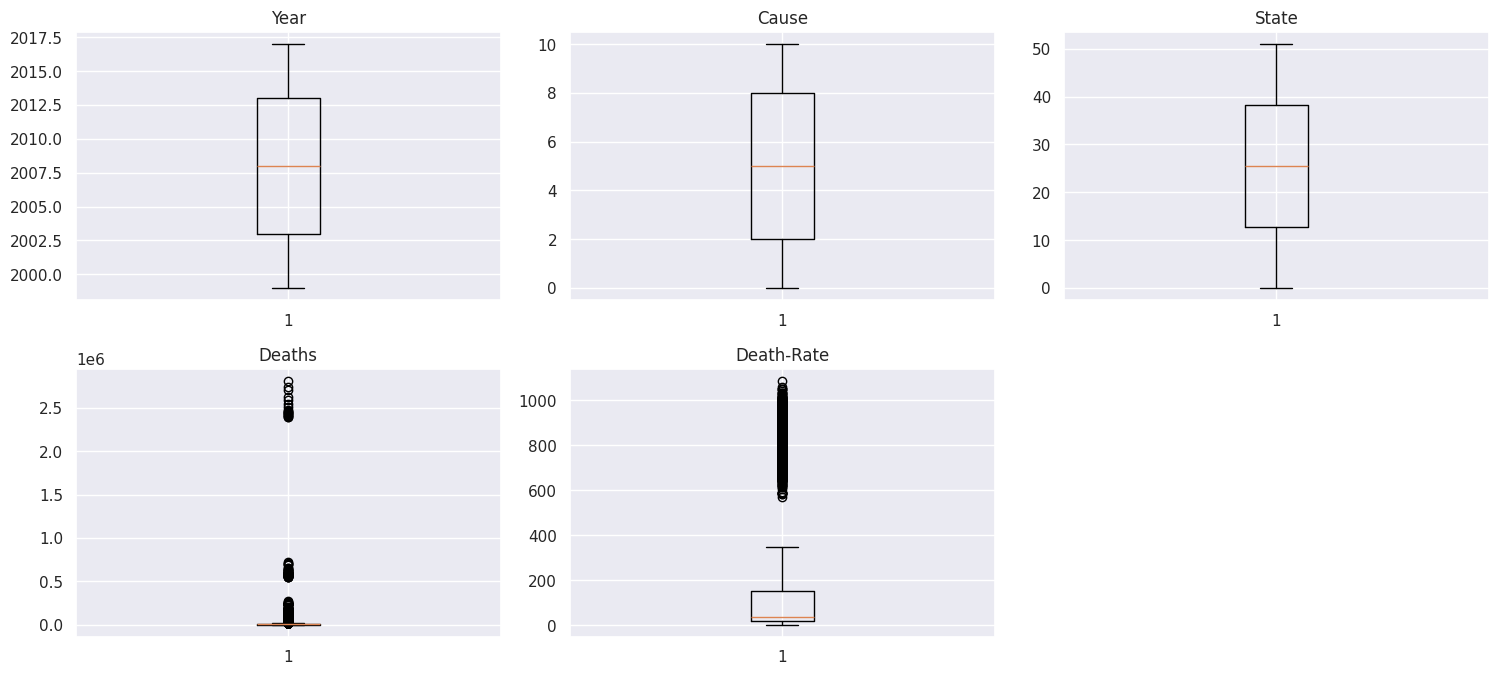

In [ ]:
columns = df.columns[:]

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 10))
axes = axes.flatten()

for i, column in enumerate(columns):
    axes[i].boxplot(df[column])
    axes[i].set_title(column)

for i in range(len(columns), len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()

### correlation

In [ ]:
df.corr()

,Year,Cause,State,Deaths,Death-Rate
Year,1.000000e+00,6.563524e-15,-3.589485e-15,0.004417,-0.038853
Cause,6.563524e-15,1.000000e+00,6.207252e-17,-0.128883,-0.533860
State,-3.589485e-15,6.207252e-17,1.000000e+00,0.078236,0.001609
Deaths,4.417442e-03,-1.288831e-01,7.823617e-02,1.000000,0.231048
Death-Rate,-3.885293e-02,-5.338601e-01,1.608964e-03,0.231048,1.000000


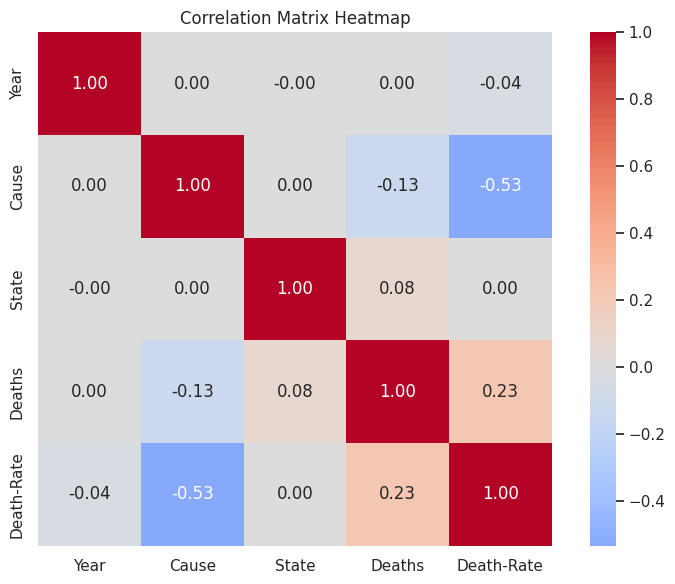

In [ ]:
corr_matrix = df.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, fmt='.2f')
plt.title('Correlation Matrix Heatmap')
plt.tight_layout()
plt.show()

### questions for visualization

In [ ]:
def plot_top_states(df):
    plt.figure(figsize=(10, 6))
    top_states = df.groupby('State')['Death-Rate'].mean().nlargest(10)

    ax = sns.barplot(x=top_states.values, y=top_states.index, palette='viridis')

    plt.title("Top 10 States by Average Death-Rate", pad=15)
    plt.xlabel("Average Death-Rate")
    plt.ylabel("")
    plt.xlim(0, top_states.max() * 1.3)
    plt.tight_layout()

    return plt.gcf()

In [ ]:
def plot_death_trends(df):
    fig, ax = plt.subplots(figsize=(8, 5))
    sns.lineplot(data=df, x='Year', y='Death-Rate', errorbar=None, ax=ax)

    ax.set_title('Death Rate Trends Over Time')
    ax.set_xlabel('Year')
    ax.set_ylabel('Death-Rate')

    plt.tight_layout()
    return fig

In [ ]:
def plot_cause_distribution(df):
    fig, ax = plt.subplots(figsize=(8, 5))
    sns.boxplot(data=df, x='Cause', y='Death-Rate', ax=ax)

    ax.set_title('Death Rate Distribution by Cause')
    ax.set_xlabel('Cause of Death')
    ax.set_ylabel('Death-Rate')
    plt.xticks(rotation=45)

    plt.tight_layout()
    return fig

In [ ]:
def plot_deaths_vs_rate(df):
    fig, ax = plt.subplots(figsize=(8, 5))
    sns.scatterplot(data=df, x='Deaths', y='Death-Rate', alpha=0.6, ax=ax)

    ax.set_title('Deaths vs. Death Rate')
    ax.set_xlabel('Number of Deaths')
    ax.set_ylabel('Death-Rate')

    plt.tight_layout()
    return fig

In [ ]:
def plot_model_errors(final_results):
    fig, ax = plt.subplots(figsize=(8, 5))
    errors = {model: final_results['test_actuals'] - final_results['predictions'][model]
             for model in final_results['predictions']}
    sns.boxplot(data=pd.DataFrame(errors), ax=ax)
    ax.axhline(0, color='red', linestyle='--')

    ax.set_title('Prediction Error Distribution by Model')
    ax.set_ylabel('Error (Actual - Predicted)')

    plt.tight_layout()
    return fig

/tmp/ipython-input-2718820265.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=top_states.values, y=top_states.index, palette='viridis')


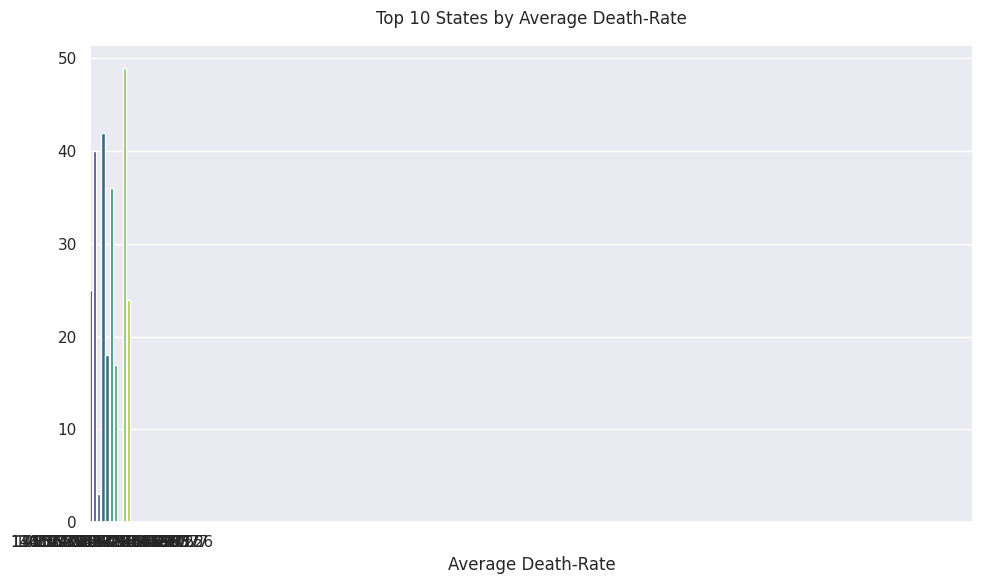

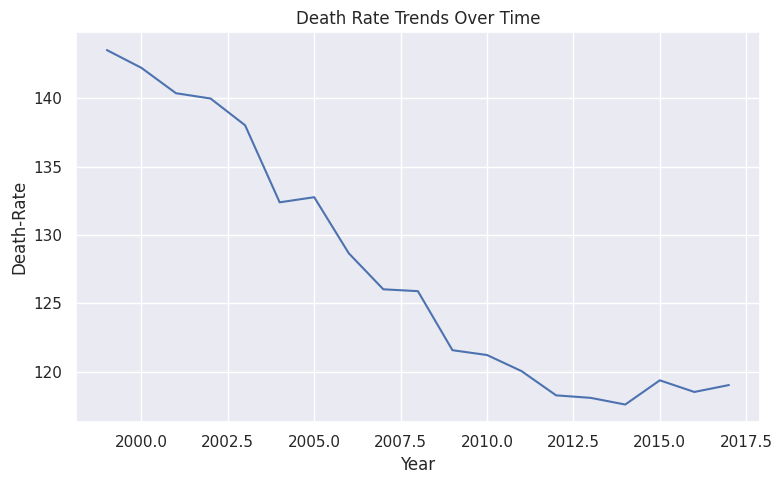

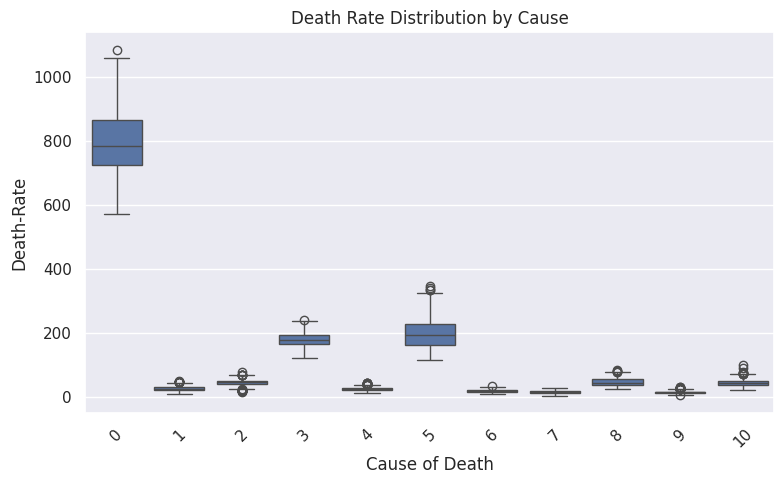

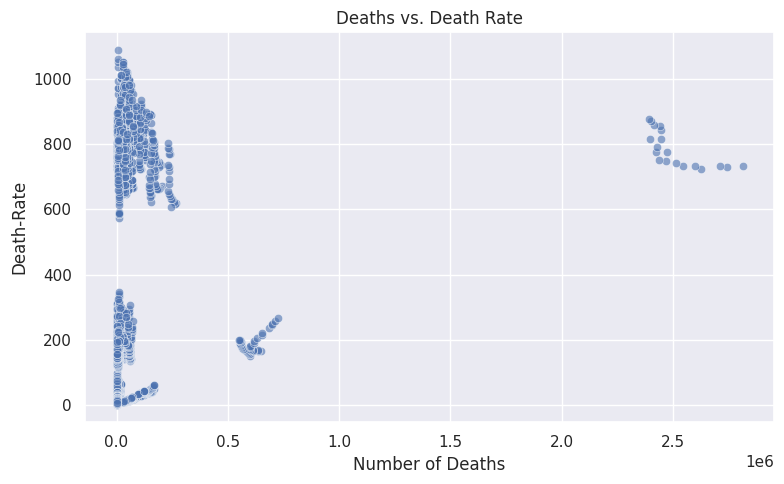

In [ ]:
plots = {
    "Top States by Death Rate": plot_top_states(df),
    "Death Rate Trends Over Time": plot_death_trends(df),
    "Death Rate by Cause": plot_cause_distribution(df),
    "Deaths vs. Death Rate": plot_deaths_vs_rate(df),
}

## predict cause of death

## modeling

### training

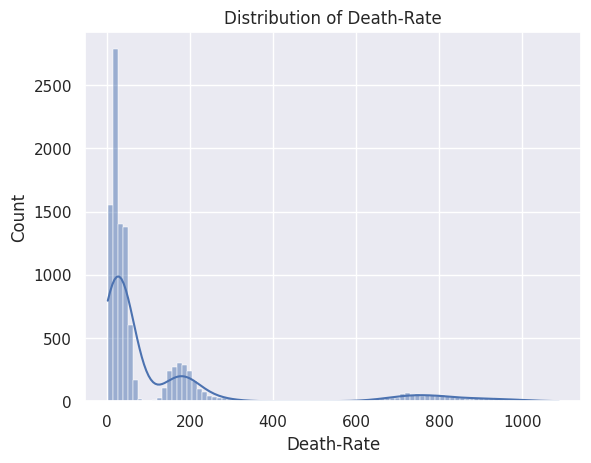

Skewness: 2.5554114376342127
Applied log transformation to Death-Rate


In [ ]:
sns.histplot(df['Death-Rate'], kde=True)
plt.title("Distribution of Death-Rate")
plt.show()

skewness = df['Death-Rate'].skew()
print(f"Skewness: {skewness}")

if abs(skewness) > 1:
    df['Death-Rate'] = np.log1p(df['Death-Rate'])
    print("Applied log transformation to Death-Rate")


#### identify features and target

In [ ]:
X = df.drop(['Death-Rate'], axis=1)
y = df['Death-Rate']

#### train-test split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### scaling

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


### identify ML models

In [ ]:
models = {
    "Random Forest": {
        "model": RandomForestRegressor(random_state=42),
        "params": {
            'n_estimators': [100, 200],
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5]
        }
    },
    "XGBoost": {
        "model": XGBRegressor(random_state=42),
        "params": {
            'n_estimators': [100, 200],
            'max_depth': [3, 6],
            'learning_rate': [0.01, 0.1]
        }
    },
    "SVR": {
        "model": SVR(),
        "params": {
            'C': [0.1, 1, 10],
            'kernel': ['linear', 'rbf'],
            'gamma': ['scale', 'auto']
        }
    },
    "KNN": {
        "model": KNeighborsRegressor(),
        "params": {
            'n_neighbors': [3, 5, 7],
            'weights': ['uniform', 'distance']
        }
    }
}

#### getting scores for each model and get the best of them


In [ ]:
results = {
    'scores': {},
    'best_params': {},
    'best_model': None,
    'best_model_name': None,
    'predictions': {}
}

for name, config in models.items():
    print(f"\n=== Tuning {name} ===")

    X_tr = X_train_scaled if name in ['SVR', 'KNN'] else X_train
    X_te = X_test_scaled if name in ['SVR', 'KNN'] else X_test

    grid = GridSearchCV(config['model'], config['params'], cv=5, scoring='r2', n_jobs=-1)
    grid.fit(X_tr, y_train)

    best_model = grid.best_estimator_

    y_train_pred = best_model.predict(X_tr)
    y_test_pred = best_model.predict(X_te)

    results['scores'][name] = {
        'RMSE': np.sqrt(mean_squared_error(y_test, y_test_pred)),
        'MAE': mean_absolute_error(y_test, y_test_pred),
        'Test R2': r2_score(y_test, y_test_pred),
        'Train R2': r2_score(y_train, y_train_pred)
    }

    results['best_params'][name] = grid.best_params_
    results['predictions'][name] = y_test_pred
    results[name] = best_model

results['best_model_name'] = min(results['scores'], key=lambda x: results['scores'][x]['RMSE'])
results['best_model'] = results[results['best_model_name']]

print("\n=== Final Results ===")
print(pd.DataFrame(results['scores']).T.round(3))

print("\n=== Best Parameters ===")
for name, params in results['best_params'].items():
    print(f"{name}: {params}")

print(f"\nBest Model: {results['best_model_name']} (RMSE: {results['scores'][results['best_model_name']]['RMSE']:.2f})")

final_results = {
    'model_scores': results['scores'],
    'best_params': results['best_params'],
    'predictions': results['predictions'],
    'best_model': results['best_model'],
    'best_model_name': results['best_model_name'],
    'test_actuals': y_test.values
}


=== Tuning Random Forest ===

=== Tuning XGBoost ===

=== Tuning SVR ===

=== Tuning KNN ===

=== Final Results ===
                RMSE    MAE  Test R2  Train R2
Random Forest  0.079  0.052    0.996     0.999
XGBoost        0.079  0.057    0.996     0.998
SVR            0.714  0.538    0.678     0.666
KNN            0.242  0.166    0.963     0.979

=== Best Parameters ===
Random Forest: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
XGBoost: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200}
SVR: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
KNN: {'n_neighbors': 3, 'weights': 'uniform'}

Best Model: XGBoost (RMSE: 0.08)


## deployment


In [ ]:
with gr.Blocks() as demo:
    gr.Markdown("<div align='center'><h1>Death Rate Prediction Dashboard</h1></div>")

    with gr.Tabs():
        with gr.Tab("📁 Dataset Overview"):
            gr.Dataframe(value=df)
            gr.Textbox(label="Dataset Size", value=f"Rows: {df.shape[0]}, Columns: {df.shape[1]}")

        with gr.Tab("📊 Exploratory Data Analysis"):
            gr.Markdown("<div align='center'><h2>📊 EDA</h2></div>")
            for title, plot in plots.items():
                gr.Markdown(f"### {title}")
                gr.Plot(plot)

        with gr.Tab("✅ Best Model Overview"):
            gr.Markdown("## ✅ Best Model Overview")
            gr.Markdown(f"**Best Model:** `{final_results['best_model_name']}`")
            gr.Markdown(f"**RMSE:** `{final_results['model_scores'][final_results['best_model_name']]['RMSE']:.2f}`")
            gr.Markdown(f"**Test R²:** `{final_results['model_scores'][final_results['best_model_name']]['Test R2']:.2f}`")
            gr.Markdown(f"**Train R²:** `{final_results['model_scores'][final_results['best_model_name']]['Train R2']:.2f}`")

            fig, ax = plt.subplots(figsize=(8, 6))
            ax.scatter(final_results['test_actuals'], final_results['predictions'][final_results['best_model_name']])
            ax.plot([min(final_results['test_actuals']), max(final_results['test_actuals'])],
                    [min(final_results['test_actuals']), max(final_results['test_actuals'])],
                    'r--')
            ax.set_title(f"Actual vs Predicted ({final_results['best_model_name']})")
            ax.set_xlabel("Actual Death-Rate")
            ax.set_ylabel("Predicted Death-Rate")
            gr.Plot(fig)
            plt.close()

        with gr.Tab("📈 Evaluate Any Model"):
          gr.Markdown("## 🔍 Evaluate Any Model")

          model_dropdown = gr.Dropdown(
              choices=list(final_results['model_scores'].keys()),
              value=final_results['best_model_name'],
              label="Select a Model"
          )

          rmse_box = gr.Textbox(label="RMSE")
          mae_box = gr.Textbox(label="MAE")
          test_r2_box = gr.Textbox(label="Test R² (Accuracy)")
          train_r2_box = gr.Textbox(label="Train R² (Accuracy)")
          pred_plot = gr.Plot(label="Actual vs Predicted")

          def update_model_evaluation(model_name):
              scores = final_results['model_scores'][model_name]
              predictions = final_results['predictions'][model_name]
              actuals = final_results['test_actuals']

              # Create Actual vs Predicted plot
              fig, ax = plt.subplots(figsize=(8, 6))
              ax.scatter(actuals, predictions)
              ax.plot(
                  [min(actuals), max(actuals)],
                  [min(actuals), max(actuals)],
                  'r--'
              )
              ax.set_title(f"Actual vs Predicted ({model_name})")
              ax.set_xlabel("Actual Death-Rate")
              ax.set_ylabel("Predicted Death-Rate")
              plt.close()

              return (
                  f"{scores['RMSE']:.2f}",
                  f"{scores['MAE']:.2f}",
                  f"{scores['Test R2']:.2f}",
                  f"{scores['Train R2']:.2f}",
                  fig
              )

          model_dropdown.change(
              fn=update_model_evaluation,
              inputs=model_dropdown,
              outputs=[rmse_box, mae_box, test_r2_box, train_r2_box, pred_plot]
          )

          demo.load(
              fn=lambda: update_model_evaluation(final_results['best_model_name']),
              inputs=[],
              outputs=[rmse_box, mae_box, test_r2_box, train_r2_box, pred_plot],
              queue=False
          )


        with gr.Tab("🤖 Predict Death-Rate"):
            gr.Markdown("<div align='center'><h2>🔮 Predict Death-Rate</h2></div>")

            with gr.Row():
                input_widgets = []
                for col in X.columns:
                    if X[col].dtype in ['int64', 'float64']:
                        input_widgets.append(gr.Number(label=col))
                    else:
                        unique_vals = df[col].unique().tolist()
                        input_widgets.append(gr.Dropdown(choices=unique_vals, label=col))

            predict_btn = gr.Button("Predict")
            prediction_output = gr.Textbox(label="Predicted Death-Rate")

            def predict_death_rate(*inputs):
                input_df = pd.DataFrame([inputs], columns=X.columns)
                num_cols = input_df.select_dtypes(include=['int64', 'float64']).columns
                input_df[num_cols] = scaler.transform(input_df[num_cols])
                prediction = final_results['best_model'].predict(input_df)[0]
                return f"Predicted Death-Rate: {prediction:.2f}"

            predict_btn.click(
                fn=predict_death_rate,
                inputs=input_widgets,
                outputs=prediction_output
            )

demo.launch()


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://3f168b14e9e5583dfb.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
